### Yasamin Panahi
### student number: 97100687

In [1]:
import matplotlib
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from math import ceil

### Order of contents in this notebook is the following:

* [Neural Network with 3 Optimizors (BGD, Adam, RMSprop)](#chapter1)
    * [A Brief explanation of each optimization method](#section_1_1)
    * [Neural Network object](sSection_1_2)
        * [Data (Social_Network_Ads - binary classification)](#section_1_2_1)
        * [Training with BGD Optimizer](#section_1_2_2)
        * [Training with Adam Optimizer](#section_1_2_3)
        * [Training with RMSprop Optimizer](#section_1_2_3)
* [Neural Network with Regularization and Drop out](#chapter2)
    * [Generate Data](#section_2_1)
    * [Weight Initialization](#section_2_2)
    * [Loss Functions](#section_2_3)
    * [Regularization](#section_2_4)
    * [Drop out](#section_2_5)
    * [Batch Normalization](#section_2_6)
    * [Layers (FeedForward & BackPropagation functions)](#section_2_7)
    * [Neural Network object](#section_2_8)
        * [Training](#section_2_8_1)
        * [Accuracy & Confusion matrix](#section_2_8_1)

## Note:
In the first neural network with 3 optimizers, i got confused in adding Regularization and Drop out in the same class, so i decided to keep the first one with three optimizers and from start write another class with just Simple GD optimizer but adding Regularization and Drop out.

# Neural Network with 3 Optimizors (BGD, Adam, RMSprop)

### 1) Batch Gradient Descent, this link:
"https://towardsdatascience.com/gradient-descent-algorithm-and-its-variants-10f652806a3"

### 2) Adam, for implementation of this optimizer i used this algorithm from the link below:
"https://towardsdatascience.com/adam-optimization-algorithm-1cdc9b12724a"

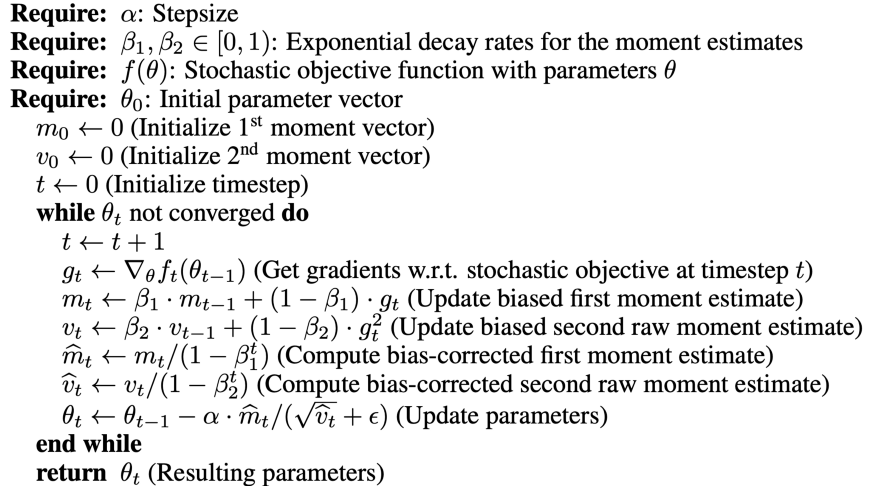

### 2) RMSprop, for implementation of this optimizer i used this algorithm from the link below:
"https://towardsdatascience.com/a-look-at-gradient-descent-and-rmsprop-optimizers-f77d483ef08b"

#### Gradient descent with momenttum:

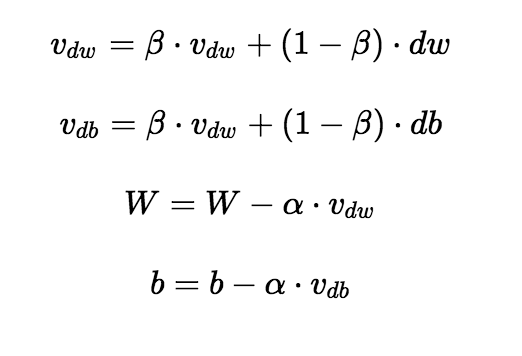

#### Weight and bias update using RMSprop optimization:

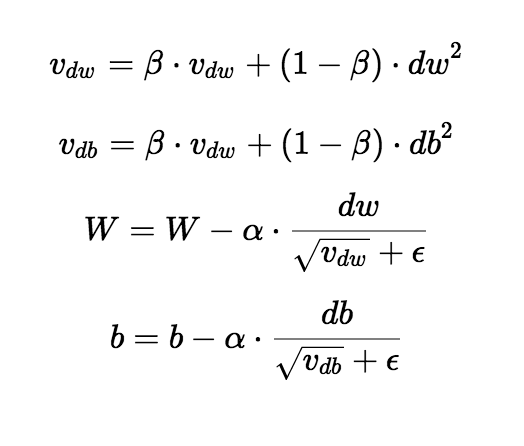

## NeuralNetwork Object:

In [2]:
class NeuralNetwork:
    
    def __init__(self, n_layers, acts, lr=0.001, iters=1000, *, optimizer=None, mini_batch_size=128, \
                 beta1=0.9, beta2=0.999, lr_decay_rate=None, lr_decay_period=None, plot_loss=True, plot_acc=True, info=False):
        
        self.iters = iters
        self.lr, self.inilr = lr, lr
        self.n_layers = n_layers
        self.acts = acts   #activation functions
        self.mbs = mini_batch_size
        self.ptl = plot_loss
        self.ptac = plot_acc
        self.info = info #showing what happens in the network
        self.b1 = beta1
        self.b2 = beta2
        self.optimizer = optimizer if optimizer else 'BGD' 
        self.epsilon = 1e-7
        self.lrdr = lr_decay_rate
        self.lrdp = lr_decay_period
        
        self.lrdp = self.iters/self.lrdp
        
        self.W, self.B, self.A, self.Z = {}, {}, {}, {} #general parameters
        self.dw, self.db, self.dz = {}, {}, {}  #parameters for Gradient Descent
        #parameters for Gradient descent with momenttum:
        self.vdw, self.vdb, self.adw, self.adb = {}, {}, {}, {}
        self.vdwc, self.vdbc, self.adwc, self.adbc = {}, {}, {}, {}
        
        self.xp, self.yp = None, None
        self.x, self.y = None, None
        
        self.mbx, self.mby = [], []
        self.loss, self.accuracy = [], []
        
        self.activations = {'sm' : self.softmax, 'r' : self.relu, 't' : self.tanh, 's' : self.sigmoid}
        self.diff_activations = {'r' : self.diff_relu, 't' : self.diff_tanh, 's' : self.diff_sigmoid} #derivative
   
    #=====================
    #       fitting
    #=====================
    def fit(self, x, y):
        self.x, self.xp = x.T, x.T
        self.n_s = y.size #number of samples
        self.y, self.yp = self.onehotencode(y).T, self.onehotencode(y).T
        
        self.create_mini_batches()
        self.initialize_weights()
        self.optimize_weights()
        
        if self.ptl:
            self.plot_loss()
            
        if self.ptac:
            self.plot_accuracy()
            
        if self.info:
            self.info =  {
                            'Optimized Weights' : self.W,
                            'Optimized Biases' : self.B,
                            'Epochs' : self.iters,
                            'Optimizer Used' : self.optimizer,
                            'Initial Learning Rate' : self.inilr,
                            'Learning Rate after decay' : self.lr,
                            'Minimised Loss' : self.loss[-1],
                            'Accuracy' : self.accuracy[-1]
                          }
            print('\n'.join([str(i)+' : '+str(self.info[i]) for i in self.info.keys()]))
            
    #======================
    #       prediction
    #======================
            
    def predict(self, x):
        
        self.A['A0'] = x.T
        for i in range(1, len(self.n_layers)):
            self.Z['Z'+str(i)] = np.dot(self.W['W'+str(i)], self.A['A'+str(i-1)]) + self.B['B'+str(i)]
            self.A['A'+str(i)] = self.activations[self.acts[i-1]](self.Z['Z'+str(i)])
            predictions = self.A['A'+str(len(self.n_layers)-1)].argmax(axis=0)
            
        return predictions
        
    def initialize_weights(self):
        for i in range(1, len(self.n_layers)):
            
            self.W['W'+str(i)] = np.random.random((self.n_layers[i], self.n_layers[i-1])) * np.sqrt(2/self.n_layers[i-1])
            self.B['B'+str(i)] = np.random.random((self.n_layers[i], 1)) * 0.001
            
            self.vdw['vdw'+str(i)] = np.zeros_like(self.W['W'+str(i)])
            self.vdb['vdb'+str(i)] = np.zeros_like(self.B['B'+str(i)])
            self.vdwc['vdwc'+str(i)] = np.zeros_like(self.W['W'+str(i)])
            self.vdbc['vdbc'+str(i)] = np.zeros_like(self.B['B'+str(i)])
            
            self.adw['adw'+str(i)] = np.zeros_like(self.W['W'+str(i)])
            self.adb['adb'+str(i)] = np.zeros_like(self.B['B'+str(i)])
            self.adwc['adwc'+str(i)] = np.zeros_like(self.W['W'+str(i)])
            self.adbc['adbc'+str(i)] = np.zeros_like(self.B['B'+str(i)])
            
    #=====================================================
    #       updating wights with different optimizors
    #=====================================================
    def optimize_weights(self):
        for _ in range(1, self.iters+1):
            for x, y in zip(self.mbx, self.mby):
                self.x = x
                self.y = y
                self.n_s = self.x.shape[1]
                self.A['A0'] = self.x
                
                self.feed_forward()
                self.back_propagation()
                
                if not _%self.lrdp:
                    self.lr /= self.lrdr
                
                for i in range(1, len(self.n_layers)):
                    
                    if self.optimizer == 'adam': #Adam optimizer
                            
                        self.adam(_)
                        self.W['W'+str(i)] -= self.lr*(self.vdwc['vdwc'+str(i)] / np.sqrt(self.epsilon+self.adwc['adwc'+str(i)]))
                        self.B['B'+str(i)] -= self.lr*(self.vdbc['vdbc'+str(i)] / np.sqrt(self.epsilon+self.adbc['adbc'+str(i)]))
                    
                    if self.optimizer == 'rms': #rms prob optimizer
                            
                        self.rms(_) 
                        self.W['W'+str(i)] -= self.lr*self.vdwc['vdwc'+str(i)]
                        self.B['B'+str(i)] -= self.lr*self.vdbc['vdbc'+str(i)]
                    
                    else:
                            
                        self.W['W'+str(i)] -= self.lr*self.dw['dw'+str(i)]
                        self.B['B'+str(i)] -= self.lr*self.db['db'+str(i)]
                    
            self.loss.append(self.loss_function(self.A['A'+str(len(self.n_layers)-1)], self.y))
            self.accuracy.append(self.compute_accuracy(self.xp, self.yp.argmax(axis=0)))
            
    #==================================================
    #    Feed Forward & Back Propagation functions
    #==================================================
            
    def feed_forward(self):
        
        for i in range(1, len(self.n_layers)):
            self.Z['Z'+str(i)] = np.dot(self.W['W'+str(i)], self.A['A'+str(i-1)]) + self.B['B'+str(i)]
            self.A['A'+str(i)] = self.activations[self.acts[i-1]](self.Z['Z'+str(i)])
    
    def back_propagation(self):
        
        for i in range(1, len(self.n_layers))[::-1]:
            
            if i==len(self.n_layers)-1:
                self.dz['dz'+str(i)] = self.A['A'+str(i)] - self.y
            else:
                self.dz['dz'+str(i)] = np.dot(self.W['W'+str(i+1)].T, self.dz['dz'+str(i+1)])*self.diff_activations[self.acts[i-1]](self.Z['Z'+str(i)])
            
            self.dw['dw'+str(i)] = np.dot(self.dz['dz'+str(i)], self.A['A'+str(i-1)].T) / self.n_s
            self.db['db'+str(i)] = np.sum(self.dz['dz'+str(i)], axis=1, keepdims=True) / self.n_s
                                           
                                           
    def loss_function(self, y_pred, y_true): #cross entropy
        
        n_s = y_true.shape[1]
        loss = - ( np.sum( np.sum( y_true*np.log(y_pred + self.epsilon), axis=0 ) ) ) / n_s
        return loss
    
    def compute_accuracy(self, x, y):
        
        predictions = self.predict(x.T) #calls prediction function in order to get y_pred
        acc = np.sum(predictions == y) / y.size 
        
        return acc*100 #accuracy of model
    
    def onehotencode(self, y):
        labels = len(np.unique(y))
        encoded_y = np.zeros((y.shape[0], labels))
        for i in range(y.shape[0]):
            encoded_y[i, y[i]] = 1
        return encoded_y
    
    #=======================
    #     Optimizers
    #=======================
    
    def adam(self, t):  #Adam
        
        self.rms(t)
        for i in range(1, len(self.n_layers)):
            
            self.adw['adw'+str(i)] = self.b2*self.adw['adw'+str(i)] + (1-self.b2)*(self.dw['dw'+str(i)]**2)
            self.adb['adb'+str(i)] = self.b2*self.adb['adb'+str(i)] + (1-self.b2)*(self.db['db'+str(i)]**2)
            
            self.adwc['adwc'+str(i)] = self.adw['adw'+str(i)] / (1 - np.power(self.b2, t))
            self.adbc['adbc'+str(i)] = self.adb['adb'+str(i)] / (1 - np.power(self.b2, t))
    
    def rms(self, t): #RMSprop
        
        for i in range(1, len(self.n_layers)):
            
            self.vdw['vdw'+str(i)] = self.b1*self.vdw['vdw'+str(i)] + (1-self.b1)*self.dw['dw'+str(i)]
            self.vdb['vdb'+str(i)] = self.b1*self.vdb['vdb'+str(i)] + (1-self.b1)*self.db['db'+str(i)]
            
            self.vdwc['vdwc'+str(i)] = self.vdw['vdw'+str(i)] / (1 - np.power(self.b1, t))
            self.vdbc['vdbc'+str(i)] = self.vdb['vdb'+str(i)] / (1 - np.power(self.b1, t))
    
    def create_mini_batches(self):  #Batch Gradient Descent
        start, end = 0, self.mbs
        if self.mbs < self.x.shape[1]:
            for i in range(ceil(self.x.shape[1] / self.mbs)):
                if i == ceil(self.x.shape[1] / self.mbs)-1:
                    self.mbx.append(self.x[:, start:])
                    self.mby.append(self.y[:, start:])
                else:
                    self.mbx.append(self.x[:, start:end])
                    self.mby.append(self.y[:, start:end])
                start += self.mbs
                end += self.mbs
        else:
            self.mbx.append(self.x)
            self.mby.append(self.y)
            
    #================
    #     plots
    #================
            
    def plot_loss(self):
        plt.figure(1)
        plt.plot(self.loss, color='g', alpha=0.7, label='Gradient Descent')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
    
    def plot_accuracy(self):
        plt.figure(2)
        plt.plot(self.accuracy, color='r', alpha=0.7, label='Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy at each Epoch')
        plt.legend()
        plt.grid(True)
        
    #====================================================
    #     activation functions and their derivatives
    #====================================================
        
    def softmax(self, z):
        t = np.exp(z)
        return t/np.sum(t, axis=0)
            
    def relu(self, z):
        return np.maximum(0, z)
    
    def diff_relu(self, z):
        return np.where(z>0, 1, 0)
    
    def tanh(self, z):
        return np.tanh(z)
    
    def diff_tanh(self, z):
        return 1 - np.square(self.tanh(z))
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def diff_sigmoid(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

### Data

In [3]:
data = pd.read_csv('D:\ML\Social_Network_Ads.csv') 

x = data.iloc[:, [2,3]].values
y = data.iloc[:, -1].values


x = StandardScaler().fit_transform(x)
x = PolynomialFeatures(degree=2).fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

### Training with BGD Optimizer

Optimized Weights : {'W1': array([[ 0.11182993,  0.58931901,  0.39670651,  0.16015947, -0.13230059,
         0.25914953],
       [-0.22298772,  0.88800985,  0.41201693,  0.16718538, -0.18976015,
         0.40920838],
       [-0.27138563,  1.08947232,  0.33328905,  0.14019963, -0.06199663,
         0.45150018],
       [-0.43539607,  1.12935387,  0.26870905, -0.00544621, -0.17544448,
         0.54766406]]), 'W2': array([[ 0.02123593,  0.13008203, -0.37566219, -0.36876661],
       [ 0.20428282,  0.74831761,  0.92803711,  1.15892859],
       [ 0.62145536,  0.59708936,  0.91346182,  0.87292314],
       [ 0.57421147,  0.64087021,  0.30482854,  0.62989332],
       [ 0.38723782,  0.58720576,  0.34274341,  0.83160647],
       [ 0.16868937,  0.4337767 ,  0.4163832 ,  0.81991178],
       [ 0.06244146,  0.06633663,  0.31846208,  0.45584864],
       [ 0.44596111,  0.9283163 ,  0.38767375,  0.5159978 ]]), 'W3': array([[ 0.83002681, -0.7141871 , -0.61966169, -0.19205039, -0.09350562,
         0.07269

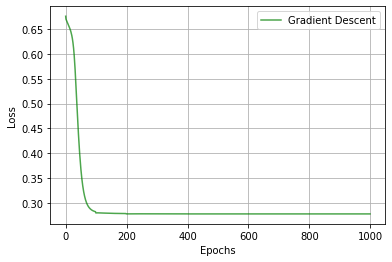

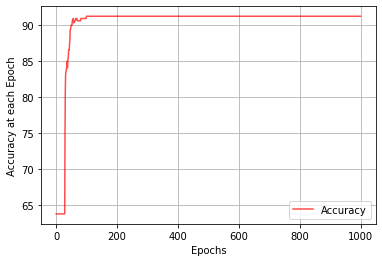

In [18]:
# Activations : tanh, sigmoid, relu
Fnn = NeuralNetwork(n_layers=[6,4,8,2], acts=['t', 's', 'sm'],lr=0.2, iters=1000, optimizer='BGD', lr_decay_period=10, lr_decay_rate=1.5, info=True)
Fnn.fit(x_train, y_train)

In [19]:
print(f"Train Accuracy with BGD Optimizer is : {Fnn.accuracy[-1] }")
print(f"Test Accuracy with BGD Optimizer is : {Fnn.compute_accuracy(x_test.T, y_test) }")

Train Accuracy with BGD Optimizer is : 91.25
Test Accuracy with BGD Optimizer is : 88.75


### Training with Adam Optimizer

Optimized Weights : {'W1': array([[-0.69061121,  1.56061478,  2.05980483, -0.05066255, -1.83395802,
         1.50933654],
       [-0.4318256 ,  1.60961628,  1.81910207, -0.08531407, -1.83292809,
         1.22074509]]), 'W2': array([[2.82425949, 2.77567093]]), 'W3': array([[-1.98921493],
       [ 3.36551583]])}
Optimized Biases : {'B1': array([[-0.92686287],
       [-0.80117164]]), 'B2': array([[-0.00542943]]), 'B3': array([[ 1.76385244],
       [-1.76330122]])}
Epochs : 1000
Optimizer Used : adam
Initial Learning Rate : 0.05
Learning Rate after decay : 2.607547525423281e-07
Minimised Loss : 0.3685975246015878
Accuracy : 92.5


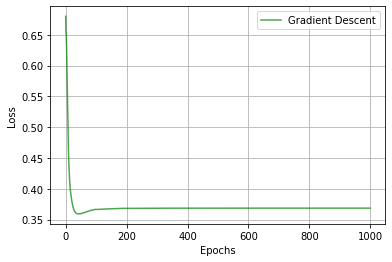

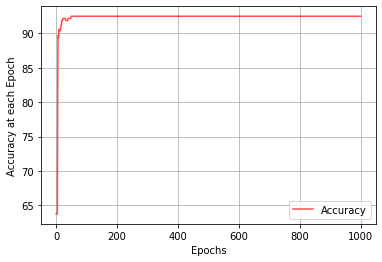

In [20]:
Fnn = NeuralNetwork(n_layers=[6,2,1,2], acts=['t', 's', 'sm'],lr=0.05, iters=1000, optimizer='adam', lr_decay_period=10, lr_decay_rate=1.5, info=True)
Fnn.fit(x_train, y_train)

In [21]:
print(f"Train Accuracy with Adam Optimizer is : {Fnn.accuracy[-1] }")
print(f"Test Accuracy with Adam Optimizer is : {Fnn.compute_accuracy(x_test.T, y_test) }")

Train Accuracy with Adam Optimizer is : 92.5
Test Accuracy with Adam Optimizer is : 90.0


### Training with RMSprop Optimizer 

Optimized Weights : {'W1': array([[-0.48359986,  0.91183051, -0.01243678, -0.07285542, -0.42312401,
         0.35798806],
       [-0.0740744 ,  0.87707487,  0.38529102, -0.04676242, -0.1567254 ,
         0.33237002],
       [-0.13807329,  0.78741409,  0.2666986 ,  0.0990717 ,  0.06260689,
         0.33106279],
       [ 0.25773527,  0.78754258,  0.75047207,  0.22082489, -0.12948303,
         0.35057286],
       [ 0.11379324,  0.36553022,  0.61933563,  0.27088142, -0.19320764,
         0.40719702],
       [ 0.30059682,  0.25679356,  0.15797937, -0.04415298,  0.31005192,
         0.64516403],
       [-0.01842787,  0.34713824,  0.14255207, -0.11509768,  0.23636641,
         0.55966963],
       [-0.12568925,  0.95386252,  0.3490082 , -0.06672746, -0.12905861,
         0.2456955 ]]), 'W2': array([[0.19547462, 0.4655074 , 0.52543684, 0.36306016, 0.30456695,
        0.51462713, 0.22503827, 0.22248383],
       [1.37360009, 0.93461439, 0.70655827, 0.29146269, 0.28924433,
        0.24563779, 0.24

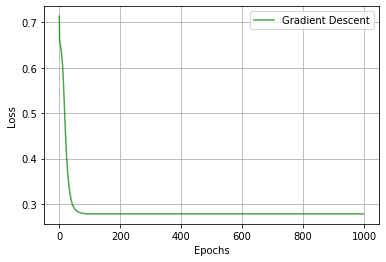

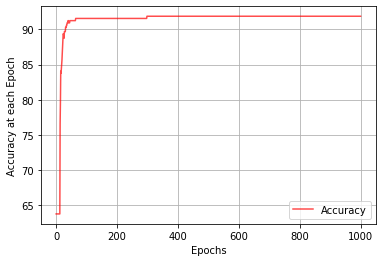

In [30]:
Fnn = NeuralNetwork(n_layers=[6,8,3,2], acts=['t', 's', 'sm'],lr=0.3, iters=1000, optimizer='rms', lr_decay_period=10, lr_decay_rate=1.5, info=True)
Fnn.fit(x_train, y_train)

In [31]:
print(f"Train Accuracy with RMSprop Optimizer is : {Fnn.accuracy[-1] }")
print(f"Test Accuracy with RMSprop Optimizer is : {Fnn.compute_accuracy(x_test.T, y_test) }")

Train Accuracy with RMSprop Optimizer is : 91.875
Test Accuracy with RMSprop Optimizer is : 88.75


# Neural Network with Regularization and Drop out

I'm using a 2-dimensional set of data in a nonlinear shape with 3 classes and 3000 samples for a classification problem as a data set for my neural network.

### Generate Data

In [32]:
''' The spiral_gen function generates a 2-dimensional set of data in a nonlinear shape with 3 classes and 3000 samples.
'''
''' this function for spiral classification data is from sklearn tutrial'''
def spiral_gen(N,n_f,n_c):
    
    # N = 100 # number of points per class
    # n_f = 2 # number of features (dimensionality)
    # n_c = 3 # number of classes
    
    X = np.zeros((N*n_c,n_f)) # data matrix (each row = single example)
    y = np.zeros(N*n_c, dtype='uint8') # class labels
    for j in range(n_c):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0,1,N) # radius
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
        #visualize the data:
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()
    return(X,y)

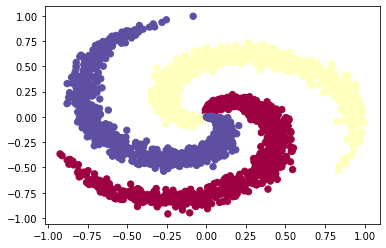

Shape of X: (3000, 2)
Shape of y: (3000,)


In [33]:
n_f  = 2 #2 features
n_c = 3 #3 classes
N = 3000 #number of samples

X,y = spiral_gen(int(N/n_c),n_f,n_c)
print('Shape of X:',X.shape)
print('Shape of y:',y.shape)

### Weight Initialization

We usually initialize the bias terms $b_i$ as zero vectors, and the weight terms $W_i$ as randomized matrices with different scaling terms.
In this part i also used two scalling methodes for initialization of weights (there is also constant scalling which makes no difference)
The motivation for using scalling comes from here: https://prateekvishnu.medium.com/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

In [34]:
def init_weights(n_f, n_c, h_list, scaling,const=0.1):
    
    ''' n_f = number of features
        n_c = number of classes '''
    
    n_layers = len(h_list) + 1
    W_list = [None] * n_layers
    b_list = [None] * n_layers
    
    #randomize weights
    for i in range(n_layers):
        #scaling term
        if scaling=='constant':
            scaler = const
        elif scaling=='xavier':
            scaler = np.sqrt(1.0 / h_list[i - 1])
        elif scaling=='he':
            scaler = np.sqrt(2.0 / h_list[i - 1])
        else:
            raise ValueError('Can only use "constant","xavier" or "he" scaling')
            
        #input layer
        if (i == 0): #layer index = 0
            W_list[i] = np.random.randn(n_f,h_list[i])
            b_list[i] = np.zeros((1,h_list[i]))
            
        #output layer
        elif (i == n_layers-1):
            W_list[i] = np.random.randn(h_list[i-1],n_c) * scaler
            b_list[i] = np.zeros((1,n_c))
            
        #hidden layers
        else:
            W_list[i] = np.random.randn(h_list[i-1],h_list[i]) * scaler
            b_list[i] = np.zeros((1,h_list[i]))
    return W_list, b_list

W_list, b_list = init_weights(2,3,[100,50],'he')
W, b = W_list[0], b_list[0]

### Loss Functions

In [35]:
'''There are two loss functions that i used,  𝐶𝑟𝑜𝑠𝑠−𝐸𝑛𝑡𝑟𝑜𝑝𝑦𝐿𝑜𝑠𝑠  and  𝐻𝑖𝑛𝑔𝑒𝐿𝑜𝑠𝑠 
 Since these two are proper loss functions for classification problem.'''

#==============================
#      Cross-Entropy Loss
#==============================
def cross_entropy(probs,y):
    #probs: N x n_c
    N = probs.shape[0]
    correct_logprobs = -np.log(probs[range(N),y])
    data_loss = np.sum(correct_logprobs) / N
    
    return(data_loss)


#========================
#      Hinge Loss
#========================
def hinge(z,y):
    N = probs.shape[0]
    
    correct_z = z[range(N),y]
   
    # need to broadcast by row not columns
    margin = z.T - correct_z + delta 
    margin = margin.T
    
    #zero loss at the correct label
    margin[range(N),y] = 0 
    
    #element-wise max
    margin = np.maximum(np.zeros(margin.shape),margin) 
    data_loss = np.sum(margin) / N
    
    return(data_loss)

### Regularization

Regularization loss is usually added to the loss function in order to prevent overfitting. It penalizes more complex weight terms.

Data loss:

$$L_{data} = \frac{1}{N}\sum_{n=1}^{N}L_i$$
Regularization loss:

$$l1 = \frac{\lambda}{2}|W|$$$$l2 = \frac{\lambda}{2}W^2$$
where $W$ is the weights

Overall loss:$$L_{overall} = L_{data} + L_{reg}$$

In [36]:
def reg_loss_calc(W_list, l2=True, reg=1e-3):
    loss = 0
    if(l2):
        for i in range(len(W_list)):
            loss += 0.5 * reg * np.sum(W_list[i]* W_list[i])
    else:
        for i in range(len(W_list)):
            loss += 0.5 * reg * np.sum(abs(W_list[i]))
    return(loss)

### Drop out

Randomly chose nodes of previous layer to be turned off. The scaler $\frac{1}{1-p}$ is added to keep the expectation of activation output the same as when there is no Dropout.

$$mask = 
\begin{cases}
\frac{1}{1-p} \ u>= p\\
0 \ u < p
\end{cases}$$
where $u$ is a sample from uniform distribution of $[0,1]$ and $p$ is the threshold for percentage of nodes to be dropped.

I read this link in order to underestand how to implement dropout layer "https://leonardoaraujosantos.gitbook.io/artificial-inteligence/machine_learning/deep_learning/dropout_layer".

quoting :
In order to implement this neuron deactivation, we create a mask(zeros and ones) during forward propagation. This mask is applied to the layer outputs during training and cached for future use on back-propagation.

In [37]:
class Dropout:
    def __init__(self,p,seed):
        self.seed = seed
        self.p = p #threshhold
    def mask(self,z,scaling=True):
        #if no dropout
        if self.p == 1: return np.ones_like(z)
        
        np.random.seed(seed=self.seed)
        if (scaling): 
            scaler = 1.0/(1-self.p)
        else:
            scaler = 1.0
        mask = scaler * np.random.binomial(n=1,p=self.p,size=z.shape)
        return(mask)

### Batch Normalization

In [38]:
'''Motivation from this link "https://www.analyticsvidhya.com/blog/2021/03/introduction-to-batch-normalization/""'''
class Norm:
    def feed_forward(self,z,epsilon = 1e-3):
        self.mu = np.mean(z,axis=0)
        self.sd = np.sqrt(np.var(z+epsilon,axis=0))
        self.N = z.shape[0]
        normalized = (z - self.mu) / self.sd
        return(normalized)
    def back_propagation(self,z,previous,epsilon = 1e-3):
        out = self.feed_forward(z,epsilon)
        dnormalized = (1-(1.0/N)) * (self.sd - (2 * np.sqrt(np.var(z,axis=0)) * (z - self.mu)**2 )/(self.N * self.sd))
        dnormalized *= previous
        return(dnormalized)

### Layers (FeedForward & BackPropagation functions)

Here for each activation function i wrote the feed forward and back propagation function. the output of feed forward function is The output of each function is what passed to the next layer of training and the derivative is what passed to the previous layer in the back propagation. There are different layers such as Linear, Sigmoid, Tanh, ReLu and Softmax.

In [39]:
'''NOTE: The Feed Forward and Back Paropagation functions are in the class specified for each activation function'''
#=====================
#       Linear
#=====================
class Linear:
    def feed_forward(self,X,W,b):
        #X: N x nz_c
        #W: n_f x n_c
        z = X.dot(W) + b #N x n_c
        return(z)
    def back_propagation(self,X,W,previous,reg=1e-3):
        #previous: N x n_c
        dW = X.T.dot(previous)
        dW += reg * W
        db = np.sum(previous,axis=0,keepdims=True)
        return dW,db
    
#=====================
#       Sigmoid
#=====================
class Sigmoid:
    def feed_forward(self,z):
        #z: N x n_c
        out = 1.0 / (1.0 + np.exp(-z))
        return out
    
    def back_propagation(self,z,previous):
        out = self.feed_forward(z)
        dz = (1.0 - out) * out * previous
        return(dz)
    
#=====================
#       Tanh
#=====================
class Tanh:
    def feed_forward(self,z):
        #z: N x n_c
        out = np.tanh(z)
        return out
    
    def back_propagation(self,z,previous):
        out = self.feed_forward(z)
        dz = (1.0 - np.square(out)) * previous
        return(dz)
#=====================
#       Relu
#=====================
class ReLu:
    def feed_forward(self,z):
        #z: N x n_c
        out = z * (z > 0)
        return out
    def back_propagation(self, z, previous):
        dz = 1.0 * (z > 0) * previous
        return(dz)

#=====================
#       Softmax
#=====================
class Softmax:
    def feed_forward(self,scores):
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return(probs)
    
    def back_propagation(self,scores,y):
        N = scores.shape[0]
        dscores = self.feed_forward(scores)
        dscores[range(N), y] -= 1
        dscores /= N
        return(dscores)   
    
    def cross_entropy(self,probs,y):
        N = probs.shape[0]

        #normalized prob of correct label
        correct_logprobs = -np.log(probs[range(N),y])

        #data loss
        data_loss = np.sum(correct_logprobs) / N

        return(data_loss)

## Neural Network Object

In [40]:
#With Simple Gradient Descent.
class Neural_Network:
    
    def __init__(self,X,y,n_f,n_c,h_list,p_list,
                 activation_list, output_activation, scaling, const=0.1):
        #parameters
        self.X=X
        self.y=y
        self.n_layers = len(h_list) + 1
        n_layers = self.n_layers
        self.h_list = h_list
        self.p_list = p_list
        self.W_list = [None] * n_layers
        self.b_list = [None] * n_layers
        self.X_list = [None] * n_layers
        self.X_list[0] = self.X

        self.act_list = [None] * n_layers
        self.lin_list = [None] * n_layers
        self.drop_list = [None] * n_layers
        self.linout_list = [None] * n_layers
        self.actout_list = [None] * n_layers
        self.mask_list = [None] * n_layers

        self.dz_list = [None] * n_layers
        self.dW_list = [None] * n_layers
        self.db_list = [None] * n_layers
    
        #randomize weights
        for i in range(n_layers):
            #scaling term
            if scaling=='constant':
                scaler = const
            elif scaling=='xavier':
                scaler = np.sqrt(1.0 / h_list[i - 1])
            elif scaling=='he':
                scaler = np.sqrt(2.0 / h_list[i - 1])
            else:
                raise ValueError('Can only use "constant","xavier" or "he" scaling')
                
            #linear layers
            self.lin_list[i] = Linear()
            if (i == 0):
                self.W_list[i] = np.random.randn(n_f,h_list[i])
                self.b_list[i] = np.zeros((1,h_list[i]))
            elif (i == n_layers-1):
                self.W_list[i] = np.random.randn(h_list[i-1],n_c) * scaler
                self.b_list[i] = np.zeros((1,n_c))
            else:
                self.W_list[i] = np.random.randn(h_list[i-1],h_list[i]) * scaler
                self.b_list[i] = np.zeros((1,h_list[i]))

            #activation layers
            seed = random.randint(1, 9999)
            if (i < n_layers-1):
                self.act_list[i] = activation_list[i]
                self.drop_list[i] = Dropout(seed=seed,p=p_list[i])
            else:
                self.act_list[i] = output_activation
                self.drop_list[i] = Dropout(seed=seed,p=1)
    
    def Info(self):
        n_layers = self.n_layers
        h_list = self.h_list
        N = self.X_list[0].shape[0]
        
        for i in range(n_layers):
                
            print('[LIN] {}: Input ({},{}), Weight {}, Bias {}, Output ({},{})'.format(i,
                N,self.W_list[i].shape[0],                                                              
                self.W_list[i].shape,
                self.b_list[i].shape,
                N,self.W_list[i].shape[1]))
            
            if (i < n_layers - 1):
                print('[ACT] {}: Input-Output ({},{}), Dropout {}, Activation {}'.format(i,N,self.W_list[i].shape[1], \
                                                                                         self.p_list[i],self.act_list[i]))
            else:
                print('[OUT] {}: Input-Output ({},{})'.format(i,N,self.W_list[i].shape[1]))
                
    #===========================================
    #    training using drop out and reg loss
    #===========================================
    def train(self,iter,reg,learning_rate,use_l2):
        n_layers = self.n_layers
        X_list = self.X_list
        act_list = self.act_list
        lin_list = self.lin_list
        actout_list = self.actout_list
        linout_list = self.linout_list
        dz_list = self.dz_list
        dW_list = self.dW_list
        db_list = self.db_list
        y = self.y
        
        for j in np.arange(iter):
            #forward
            for i in range(n_layers):
                linout_list[i] = lin_list[i].feed_forward(X_list[i],self.W_list[i],self.b_list[i])
                actout_list[i] = act_list[i].feed_forward(linout_list[i])
                #dropout
                self.mask_list[i] = self.drop_list[i].mask(actout_list[i])
                actout_list[i] *= self.mask_list[i]
                if (i < n_layers-1): X_list[i+1] = actout_list[i]

            if type(act_list[n_layers-1]) is Softmax:
                data_loss = act_list[n_layers-1].cross_entropy(actout_list[n_layers-1],y)
            else:
                data_loss = act_list[n_layers-1].hinge(actout_list[n_layers-1],y)
            reg_loss = reg_loss_calc(self.W_list,l2=use_l2,reg=reg)
            loss = data_loss + reg_loss

            if j % (iter/10) == 0:
                print('Loss at iteration {}: {}'.format(j,loss))

            #backward
            for i in reversed(range(n_layers)):
                #backward activation
                if i < n_layers-1:
                    dz_list[i] = act_list[i].back_propagation(X_list[i+1],dz_list[i+1].dot(self.W_list[i+1].T))
                    #dropout
                    dz_list[i] *= self.mask_list[i]
                else:
                    dz_list[i] = act_list[i].back_propagation(linout_list[i],y)   

                #backward linear
                dW_list[i],db_list[i] = lin_list[i].back_propagation(X_list[i],self.W_list[i],dz_list[i],reg=reg)

            #update
            for i in range(n_layers):
                self.W_list[i] -= learning_rate * dW_list[i]
                self.b_list[i] -= learning_rate * db_list[i]  

    def predict(self,X):
        n_layers = self.n_layers
        X_list = self.X_list
        X_list[0] = X
        act_list = self.act_list
        lin_list = self.lin_list
        actout_list = self.actout_list
        linout_list = self.linout_list
        W_list = self.W_list
        b_list= self.b_list
        
        for i in range(n_layers):
            linout_list[i] = lin_list[i].feed_forward(X_list[i],W_list[i],b_list[i])
            actout_list[i] = act_list[i].feed_forward(linout_list[i])
            if (i < n_layers-1): X_list[i+1] = actout_list[i]
        y_pred = np.argmax(actout_list[n_layers-1], axis=1)
        return y_pred

### Training

In [41]:
#FNN = Feed Forward Neural Network
# As an example i used Relu as activation function with 2 hidden layers and 'he' for scalling.
# for activation functions other options are also available (Tanh, Sigmoid, Softmax,Relu) and also 'xavier' and 'constant' scallings can be used instead of 'he'.
FNN = Neural_Network(X,y,n_f,n_c,h_list=[100,50],p_list=[0.5,0.5],
                activation_list=[ReLu(),ReLu()],output_activation=Softmax(),scaling='he')

In [42]:
FNN.Info()

[LIN] 0: Input (3000,2), Weight (2, 100), Bias (1, 100), Output (3000,100)
[ACT] 0: Input-Output (3000,100), Dropout 0.5, Activation <__main__.ReLu object at 0x000001B75620B160>
[LIN] 1: Input (3000,100), Weight (100, 50), Bias (1, 50), Output (3000,50)
[ACT] 1: Input-Output (3000,50), Dropout 0.5, Activation <__main__.ReLu object at 0x000001B75620B850>
[LIN] 2: Input (3000,50), Weight (50, 3), Bias (1, 3), Output (3000,3)
[OUT] 2: Input-Output (3000,3)


In [43]:
%%time
# reg can be zero and then no regularization will happen
FNN.train(iter=1000,reg=1e-3,learning_rate=1e-0,use_l2=True)

Loss at iteration 0: 1.667267575191658
Loss at iteration 100: 0.349311371075156
Loss at iteration 200: 0.2577645544154266
Loss at iteration 300: 0.22658264617622262
Loss at iteration 400: 0.2110614620247783
Loss at iteration 500: 0.19932970333386132
Loss at iteration 600: 0.18950650964992344
Loss at iteration 700: 0.18620377110473757
Loss at iteration 800: 0.17559745693612552
Loss at iteration 900: 0.17295487670212428
Wall time: 35.1 s


### Accuracy & Confusion matrix

In [44]:
''' this two functions for plotting decision_boundary and confusion matrix are from sklearn tutrial'''
import itertools
def plot_decision_boundary(pred_func,X,y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy: 0.9746666666666667


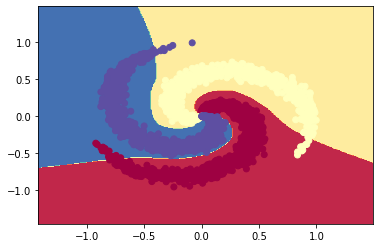

In [45]:
print('Accuracy: {}'.format(np.mean(y == FNN.predict(X))))
plot_decision_boundary(FNN.predict,X,y)

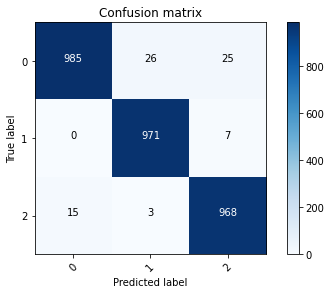

In [46]:
cm = confusion_matrix(FNN.predict(X), y)
plot_confusion_matrix(cm,[0,1,2])